Initial Data Exploration

Load the dataset using Pandas. Check for null values and understand data types.
Examine the time series properties of the data (e.g., frequency, trends).

In [55]:
#1. Data Loading and Exploration
import pandas as pd
import numpy as np

df = pd.read_csv('Apple Stock Prices (1981 to 2023).csv', header= 0)
print(df.head())
print(df.info())
print(df.describe())

#No null values
#Date is as string, it will require a tranformation to datetime
# Parse the Date column (dd/mm/yyyy format)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True) #dayFirst as true to ensure no ambiguity during transformation

         Date      Open      High       Low     Close  Adj Close    Volume
0  02/01/1981  0.154018  0.155134  0.154018  0.154018   0.119849  21660800
1  05/01/1981  0.151228  0.151228  0.150670  0.150670   0.117244  35728000
2  06/01/1981  0.144531  0.144531  0.143973  0.143973   0.112032  45158400
3  07/01/1981  0.138393  0.138393  0.137835  0.137835   0.107256  55686400
4  08/01/1981  0.135603  0.135603  0.135045  0.135045   0.105085  39827200
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10608 entries, 0 to 10607
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10608 non-null  object 
 1   Open       10608 non-null  float64
 2   High       10608 non-null  float64
 3   Low        10608 non-null  float64
 4   Close      10608 non-null  float64
 5   Adj Close  10608 non-null  float64
 6   Volume     10608 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 580.3+ KB
None
             

compréhension de chaque feature

TEMPORAL DATA ANALYSIS

Date
1 days    8317
3 days    1927
4 days     265
2 days      95
5 days       2
7 days       1
Name: count, dtype: int64


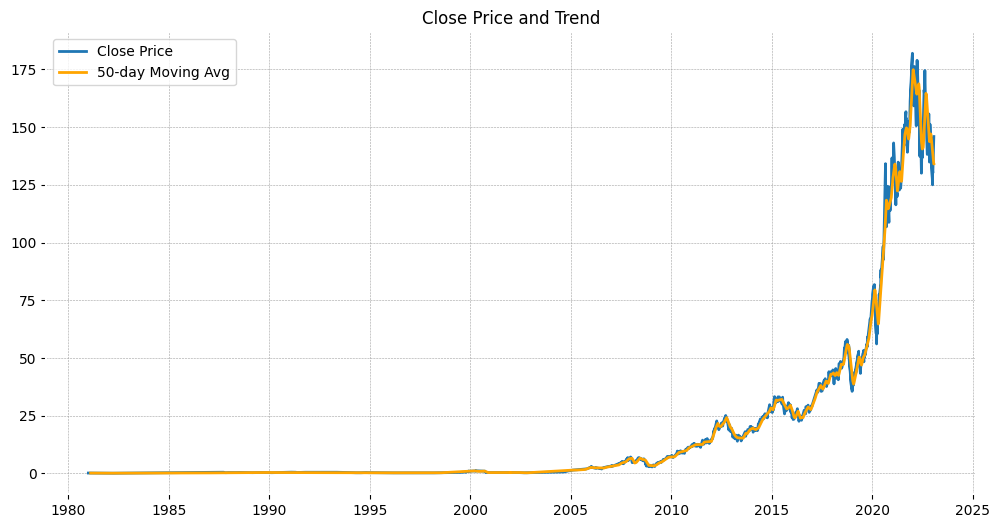

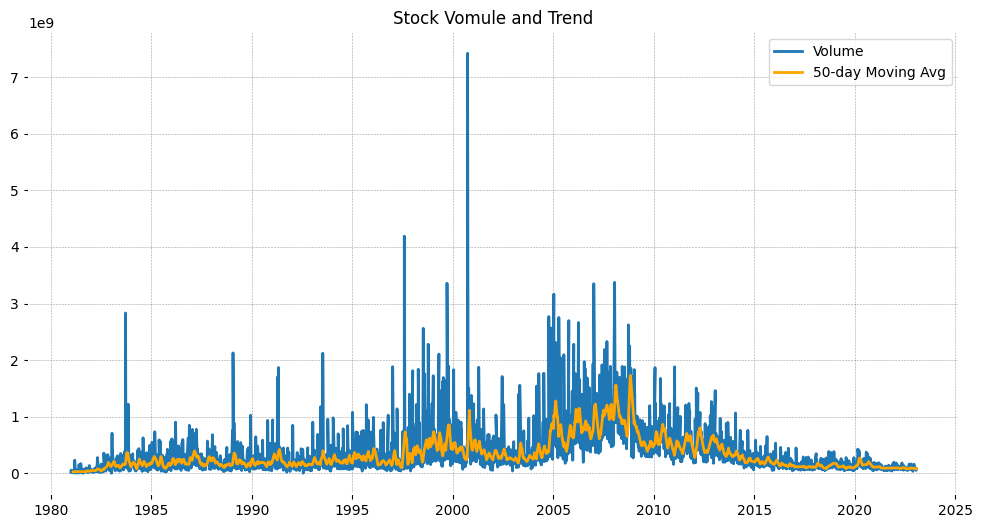

In [56]:

#Frequency on time series
freq = df['Date'].diff().value_counts()
print(freq)
# The dataset exhibits a daily frequency, consistent with trading days.
# Most observations are spaced 1 day apart, with regular 3-day gaps that likely correspond to weekends.
# Occasional longer gaps may consist in market holidays.

#Trends
import matplotlib.pyplot as plt
#Close Price
# Numeric X for regression (e.g., days since start)
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.plot(df['Date'], df['Close'].rolling(window=30).mean(), label='50-day Moving Avg', color='orange')
plt.legend()
plt.title("Close Price and Trend")
plt.show()

#Volume
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Volume'], label='Volume')
plt.plot(df['Date'], df['Volume'].rolling(window=30).mean(), label='50-day Moving Avg', color='orange')
plt.legend()
plt.title("Stock Vomule and Trend")
plt.show()

#All price-related variables (Open, High, Low, Close, Adj Close) display a long-term upward trend, with what appears to be exponential growth over the time period.
#The trading volume follows a bell-shaped curve, peaking in the early 2000s.

Volatiliy Study

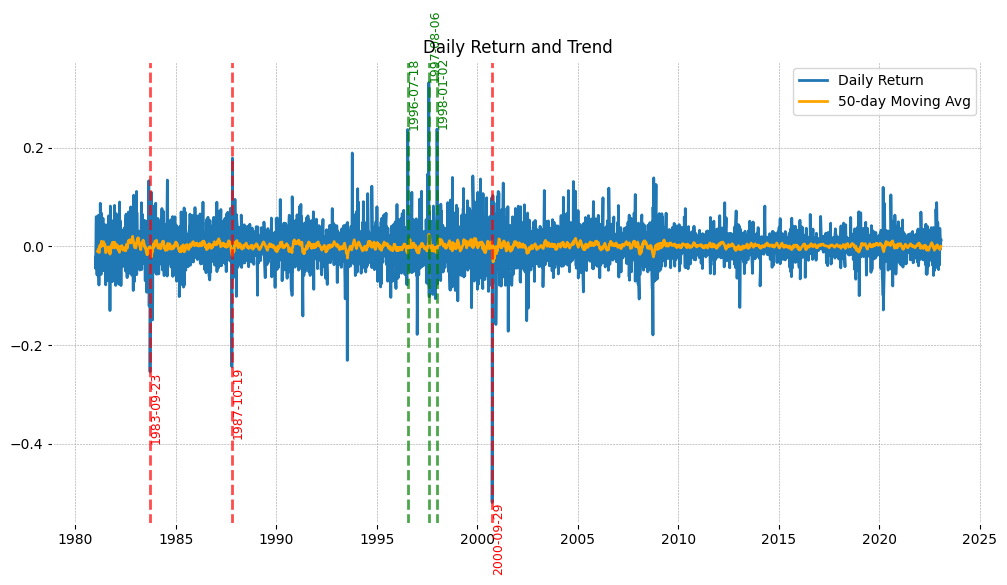

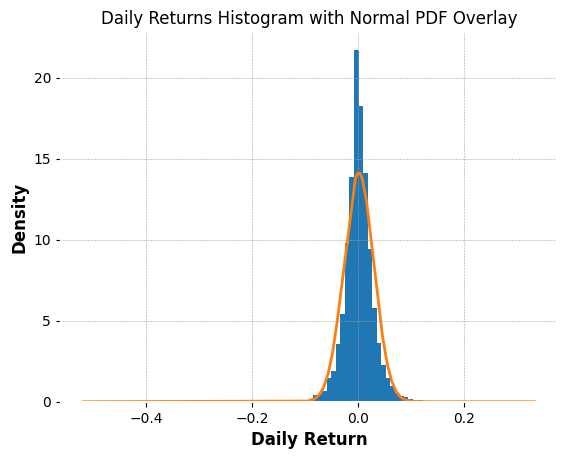

Skewness: -0.3753
Kurtosis: 18.1363


In [59]:
#Ploting 'Daily return'
#Adding column 'Daily Return' to dataframe and cleaning
df['Daily Return'] = df['Close'].pct_change()
# Top 3 gain days
top_spikes = df.sort_values('Daily Return', ascending=False).head(3)
# Top 3 loss days
worst_drops = df.sort_values('Daily Return').head(3)
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Daily Return'], label='Daily Return')
plt.plot(df['Date'], df['Daily Return'].rolling(window=30).mean(), label='50-day Moving Avg', color='orange')
# Mark top gain days
for _, row in top_spikes.iterrows():
    plt.axvline(x=row['Date'], color='green', linestyle='--', alpha=0.7)
    plt.text(row['Date'], row['Daily Return'], f"{row['Date'].date()}", 
             color='green', fontsize=9, rotation=90, verticalalignment='bottom')
# Mark top loss days
for _, row in worst_drops.iterrows():
    plt.axvline(x=row['Date'], color='red', linestyle='--', alpha=0.7)
    plt.text(row['Date'], row['Daily Return'], f"{row['Date'].date()}", 
             color='red', fontsize=9, rotation=90, verticalalignment='top')
plt.legend()
plt.title("Daily Return and Trend")
plt.show()
#Except for epiphenomenons of spikes/drops daily return is not that volatile. Such as suggest the rolling on 30 days.
returns = df['Daily Return'].iloc[1:]  # drop the first artificial 0 if you filled it

mean = returns.mean()
std = returns.std()

plt.figure()
# histogram
plt.hist(returns, bins=100, density=True)
# normal curve
x = np.linspace(returns.min(), returns.max(), 200)
pdf = 1/(std*np.sqrt(2*np.pi)) * np.exp(-(x-mean)**2/(2*std**2))
plt.plot(x, pdf)
plt.title('Daily Returns Histogram with Normal PDF Overlay')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.grid(True)
plt.show()
print(f"Skewness: {skew:.4f}")
print(f"Kurtosis: {kurt:.4f}")
#Negative Skewness (–0.3753)
#Daily returns lean slightly to the left, meaning that large negative outliers are more common (or more extreme) than large positive ones.
#In practice, this suggests a modest “downside bias” in Apple’s return distribution.
#Very High Excess Kurtosis (18.1363)
#A value of ~18 is extremely large, indicating very fat tails.
#In other words, extreme returns—both big gains and big losses—happen far more often than under a normal assumption.

Correlations Study

Pearson r: 0.273
Spearman ρ: 0.246


/opt/homebrew/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


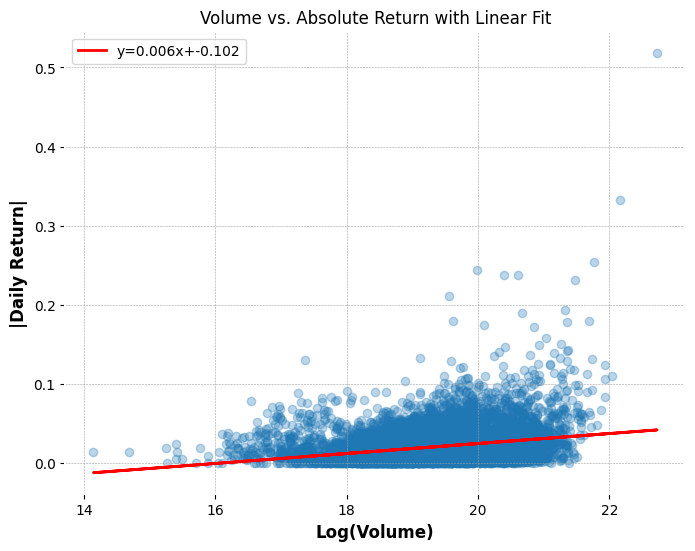

In [71]:
#We will look into correlation between Daily Returns and Volumes
df['Log Volume'] = np.log(df['Volume'])
df['Abs Return'] = df['Daily Return'].abs()
clean = df[['Abs Return', 'Log Volume']].iloc[1:].replace([np.inf, -np.inf], np.nan).dropna()
# Pearson (linear) correlation
pearson_r = clean['Abs Return'].corr(clean['Log Volume'], method='pearson')

# Spearman (rank) correlation
spearman_rho = clean['Abs Return'].corr(clean['Log Volume'], method='spearman')

print(f"Pearson r: {pearson_r:.3f}")
print(f"Spearman ρ: {spearman_rho:.3f}")
#A Pearson r of 0.273 and a Spearman ρ of 0.246 both point to a modest but clear positive association between trading volume and the magnitude of daily returns.
#In practical terms:
# Higher‐than‐normal volume days tend to coincide with larger price moves (in absolute terms).
# The fact that Spearman is only slightly lower than Pearson suggests that the relationship is roughly linear in rank space—and not driven purely by a few extreme outliers.

x = clean['Log Volume']
y = clean['Abs Return']

# Fit a simple linear model
m, b = np.polyfit(x, y, 1)

plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.3)
plt.plot(x, m*x + b, color='red', linewidth=2, label=f'y={m:.3f}x+{b:.3f}')
plt.xlabel('Log(Volume)')
plt.ylabel('|Daily Return|')
plt.title('Volume vs. Absolute Return with Linear Fit')
plt.legend()
plt.grid(True)
plt.show()

